In [ ]:
# Pulling data from Kaggle
"""!pip install -q kaggle

from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

%cd /content/drive/MyDrive/Prepare_Data

! kaggle datasets download andrewmvd/face-mask-detection"""

"!pip install -q kaggle\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n! mkdir ~/.kaggle\n!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json\n\n%cd /content/drive/MyDrive/Prepare_Data\n\n! kaggle datasets download andrewmvd/face-mask-detection"

In [ ]:
# All you have to do is run the above code once to download the dataset.
# To connect to your own Drive, you need to run this code at runtime.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# With the help of this code, I extract and transfer the data set that I downloaded to my own Drive from the zip file to the environment where I will work.
!unzip "/content/drive/MyDrive/Dataset/face-mask-detection.zip" -d "/content/face-mask-detection/"

Archive:  /content/drive/MyDrive/Dataset/face-mask-detection.zip
  inflating: /content/face-mask-detection/annotations/maksssksksss0.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss1.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss10.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss100.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss101.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss102.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss103.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss104.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss105.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss106.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss107.xml  
  inflating: /content/face-mask-detection/annotations/maksssksksss108.xml  
  inflating: /content/face-m

In [ ]:
# I import libraries that I will use.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preparing
import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil

from PIL import Image, ImageOps

In [ ]:
# Tagged data in XML format
with open('/content/face-mask-detection/annotations/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

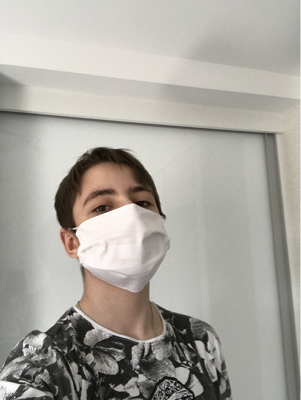

In [ ]:
# A visual from inside the data set
Image.open("/content/face-mask-detection/images/maksssksksss17.png")

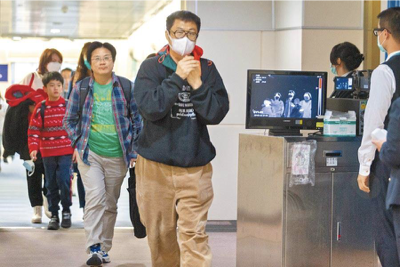

In [ ]:
# A visual from inside the data set
Image.open("/content/face-mask-detection/images/maksssksksss179.png")

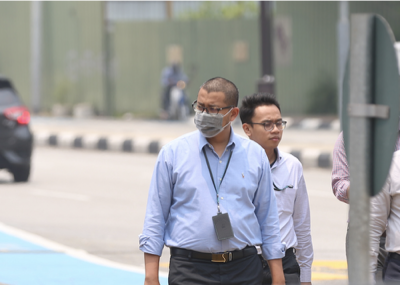

In [ ]:
# A visual from inside the data set
Image.open("/content/face-mask-detection/images/maksssksksss38.png")

In [ ]:
# Converting XML format data to TXT format
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) /w
    y_center = ((bbox[3] + bbox[1]) / 2) / h

    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center, width, height
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2

    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)

    return [xmin, ymin, xmax, ymax]

classes = ["without_mask", "with_mask", "mask_weared_incorrect"]

input_dir = "/content/face-mask-detection/annotations"
output_dir = "/content/labels"
image_dir = "/content/face-mask-detection/images"


if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

import glob

files = glob.glob(os.path.join(input_dir, "*.xml"))
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # Parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text

        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a yolo format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding = "utf-8") as f:
            f.write("\n".join(result))
# generate the classes file as reference
with open("/content/classes.txt", "w", encoding = "utf-8") as f:
    f.write(json.dumps(classes))

In [ ]:
# Labels in the data set
with open('/content/classes.txt') as f:
    contents = f.read()
    print(contents)


["without_mask", "with_mask", "mask_weared_incorrect"]


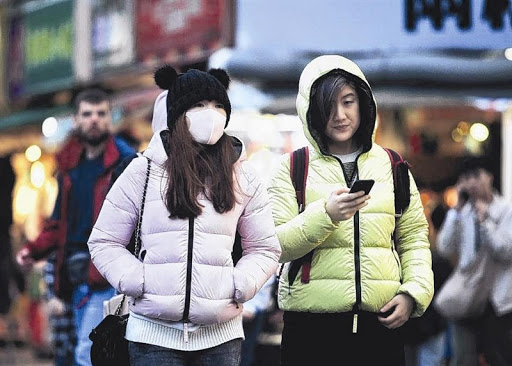

In [ ]:
# An image in the Data Set
Image.open("/content/face-mask-detection/images/maksssksksss0.png")x

In [ ]:
# XML format tag of the image above.
with open('/content/face-mask-detection/annotations/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [ ]:
# TXT version of the above label in XML format
with open('/content/labels/maksssksksss0.txt') as f:
    contents = f.read()
    print(contents)

0 0.18359375 0.337431693989071 0.05859375 0.10109289617486339
1 0.4013671875 0.3333333333333333 0.080078125 0.12021857923497267
0 0.6689453125 0.3155737704918033 0.068359375 0.13934426229508196


create data for yolov8

In [ ]:
# Names and creation of files prepared for YoloV8
if os.path.isfile("/content/data/"):
    print("There is folder!")
else:
    os.mkdir("/content/data/")
    os.mkdir('/content/data/train')
    os.mkdir('/content/data/val')
    os.mkdir('/content/data/test')
    os.mkdir('/content/data/train/images')
    os.mkdir('/content/data/train/labels')
    os.mkdir('/content/data/test/images')
    os.mkdir('/content/data/test/labels')
    os.mkdir('/content/data/val/images')
    os.mkdir('/content/data/val/labels')

In [ ]:
# Listing the names of image data together
metarial = []

for i in os.listdir("/content/face-mask-detection/images"):
    srt = i[:-4]
    metarial.append(srt)

In [ ]:
# Initial data of list
metarial[0:10]

['maksssksksss194',
 'maksssksksss236',
 'maksssksksss753',
 'maksssksksss107',
 'maksssksksss141',
 'maksssksksss743',
 'maksssksksss760',
 'maksssksksss491',
 'maksssksksss137',
 'maksssksksss528']

In [ ]:
# Data set creation function
def preparinbdata(main_txt_file, main_img_file, train_size, test_size, val_size):

    for i in range(0,train_size):

        source_txt = main_txt_file + "/" + metarial[i] + ".txt"
        source_img = main_img_file + "/" + metarial[i] + ".png"

        mstring = metarial[i]
        train_destination_txt = "/content/data/train/labels" + "/" + metarial[i] + ".txt"
        train_destination_png = "/content/data/train/images" + "/" + metarial[i] + ".png"

        shutil.copy(source_txt, train_destination_txt)
        shutil.copy(source_img, train_destination_png)

        #metarial.remove(file_name[:-4])


    for l in range(train_size , train_size + test_size):

        source_txt = main_txt_file + "/" + metarial[l] + ".txt"
        source_img = main_img_file + "/" + metarial[l] + ".png"

        mstring = metarial[l]
        test_destination_txt = "/content/data/test/labels" + "/" + metarial[l] + ".txt"
        test_destination_png = "/content/data/test/images" + "/" + metarial[l] + ".png"

        shutil.copy(source_txt, test_destination_txt)
        shutil.copy(source_img, test_destination_png)

        #metarial.remove(file_name[:-4])


    for n in range(train_size + test_size , train_size + test_size + val_size):

        source_txt = main_txt_file + "/" + metarial[n] + ".txt"
        source_img = main_img_file + "/" + metarial[n] + ".png"

        mstring = metarial[n]
        val_destination_txt = "/content/data/val/labels" + "/" + metarial[n] + ".txt"
        val_destination_png = "/content/data/val/images" + "/" + metarial[n] + ".png"

        shutil.copy(source_txt, val_destination_txt)
        shutil.copy(source_img, val_destination_png)

        #metarial.remove(file_name[:-4])

In [ ]:
# I'm streaming data
preparinbdata("/content/labels", "/content/face-mask-detection/images", 603, 150, 100)

In [ ]:
# configure .yaml file to guide the model for training
%cd /content/data

yaml_text = """train: /content/data/train/images
val: /content/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("/content/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

/content/data
cat: data/data.yaml: No such file or directory


YOLOV8


In [ ]:
# We install the 'ultralytics' library to use the YoloV8 library
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.9/112.6 GB disk)


Training

In [ ]:
# /content/data
if os.path.isfile("/content/Result/"):
    print("Dosya mevcut! (There is folder!)")
else:
    os.mkdir("/content/Result/")

%cd /content/Result/

# I am doing YoloV8 model 50 step training
# data = "Path to the file with .yaml extension"
# epochs = How many steps will you train?
# imagsz = This is size of image at the training data
!yolo train model=yolov8n.pt data=/content/data/data.yaml epochs=50 imgsz=640

/content/Result
100% 6.25M/6.25M [00:00<00:00, 88.3MB/s]
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100

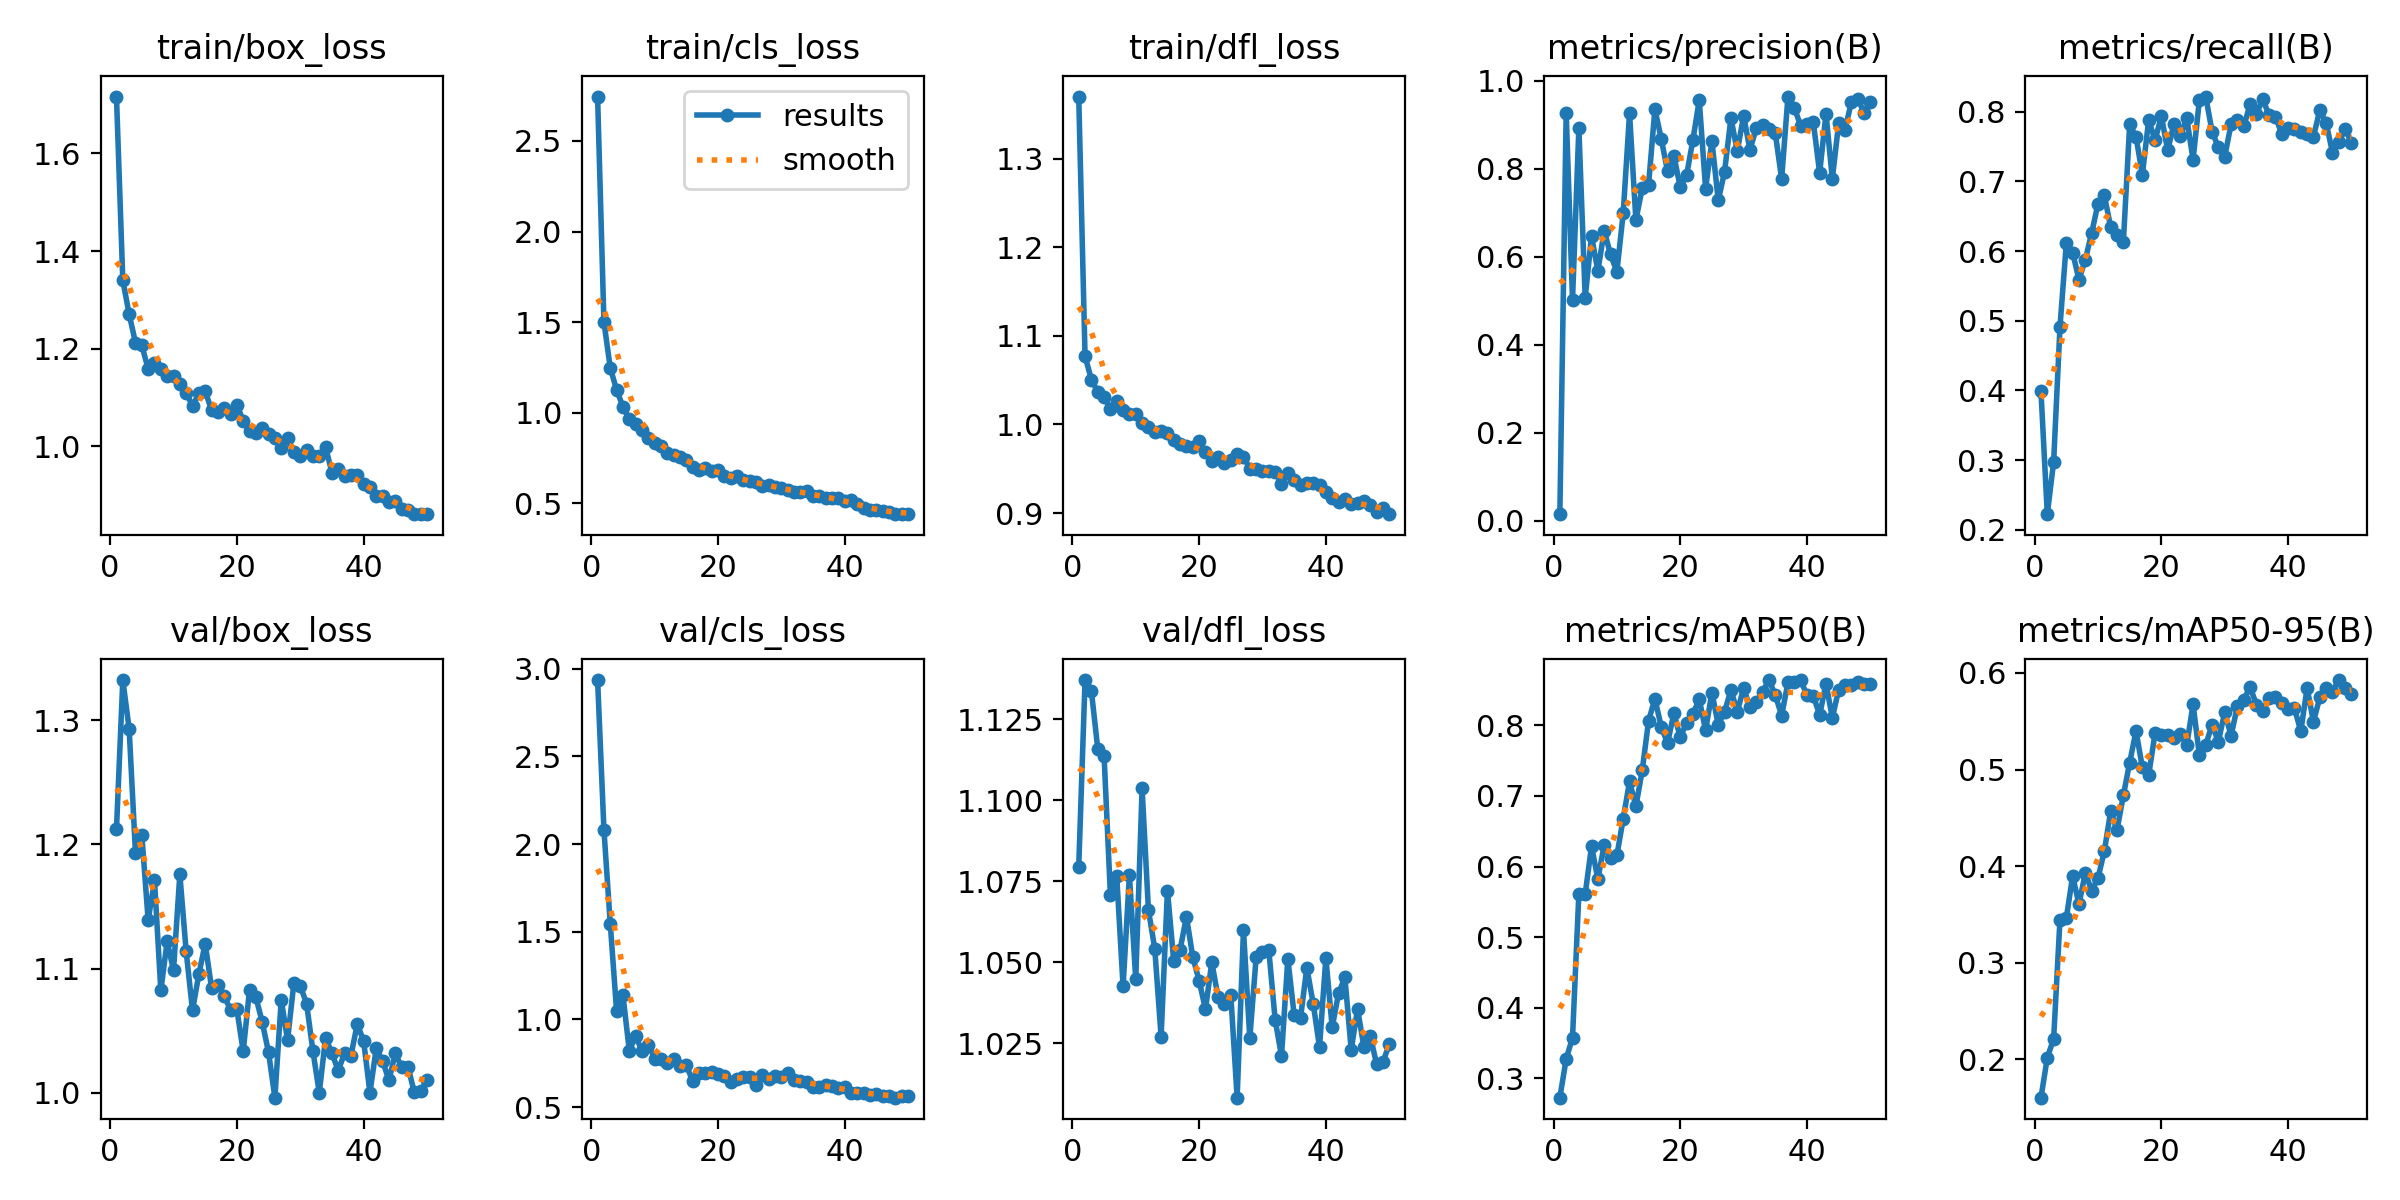

In [ ]:
# The result of my training
Image.open("/content/Result/runs/detect/train/results.png")

In [ ]:
# The detection process we performed on the test data set
# model = 'best.pt' is the step with the best score of the model I trained.
# soruce = Image or image folder of detection operations
!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/data/test/images'

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/150 /content/data/test/images/maksssksksss1.png: 256x640 1 without_mask, 7 with_masks, 42.1ms
image 2/150 /content/data/test/images/maksssksksss10.png: 640x512 1 with_mask, 36.0ms
image 3/150 /content/data/test/images/maksssksksss100.png: 384x640 2 with_masks, 34.4ms
image 4/150 /content/data/test/images/maksssksksss104.png: 448x640 7 without_masks, 2 with_masks, 35.0ms
image 5/150 /content/data/test/images/maksssksksss108.png: 384x640 1 without_mask, 8 with_masks, 6.6ms
image 6/150 /content/data/test/images/maksssksksss115.png: 448x640 1 without_mask, 11 with_masks, 6.8ms
image 7/150 /content/data/test/images/maksssksksss128.png: 640x512 1 without_mask, 6.7ms
image 8/150 /content/data/test/images/maksssksksss132.png: 640x512 1 mask_weared_incorrect, 7.4ms
image 9/150 /content/data/test/images/maksssksksss134.png: 38

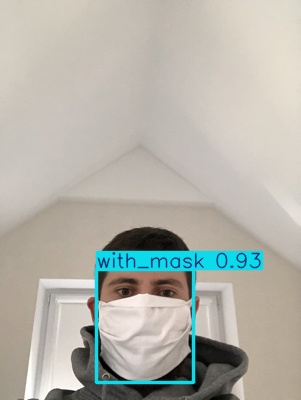

In [ ]:
# Detection result - 1
Image.open('/content/Result/runs/detect/predict/maksssksksss10.jpg')

In [ ]:
# Detection result - 2
Image.open('/content/Result/runs/detect/predict/maksssksksss229.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '/content/Result/runs/detect/predict/maksssksksss229.jpg'

In [ ]:
# Detection result - 3
Image.open('/content/Result/runs/detect/predict/maksssksksss67.jpg')

In [ ]:
# Download the real-world data
%cd /content
!wget "https://onecms-res.cloudinary.com/image/upload/s--XV7DHKzY--/c_fill,g_auto,h_468,w_830/f_auto,q_auto/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A"

# I check my upload and then change the name of the image I downloaded
if os.path.isfile("/content/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A"):
  os.rename("people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A", "image.jpg")

In [ ]:
# Detection on real-world
%cd /content/Result
!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/image.jpg'

In [ ]:
# Result of detection
Image.open('/content/Result/runs/detect/predict2/image.jpg')

In [ ]:
# Download the real-world data
%cd /content
!wget "https://cloudfront-us-east-2.images.arcpublishing.com/reuters/KPYTVDNVAZIOFDEB2JJN4BHYFU.jpg"

In [ ]:
# I check my upload and then change the name of the image I downloaded
if os.path.isfile("/content/KPYTVDNVAZIOFDEB2JJN4BHYFU.jpg"):
  os.rename("KPYTVDNVAZIOFDEB2JJN4BHYFU.jpg", "image2.jpg")


In [ ]:
# Detection on real-world
%cd /content/Result
!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/image2.jpg'

In [ ]:
# Result of detection
Image.open('/content/Result/runs/detect/predict3/image2.jpg')


In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
drive_model_path = "/content/drive/MyDrive/yolov8/best.pt"
training_model_path = "/content/Result/runs/detect/train/weights/best.pt"

# Ensure /content/Result exists
if not os.path.isdir("/content/Result"):
    os.mkdir("/content/Result")
%cd /content/Result

# Check if model already saved in Drive
if os.path.exists(drive_model_path):
    print("Using pre-saved model from Drive.")
    final_model_path = drive_model_path

else:
    print("No pre-saved model found. Starting training...")
    !yolo train model=yolov8n.pt data=/content/data/data.yaml epochs=50 imgsz=640

    # After training, save model to Drive
    if os.path.exists(training_model_path):
        !cp {training_model_path} {drive_model_path}
        print("Training complete. Model copied to Drive.")
        final_model_path = training_model_path
    else:
        raise FileNotFoundError("Training failed or model not saved!")

# ✅ Use final_model_path for prediction
print("Running prediction using:", final_model_path)
!yolo predict model={final_model_path} source='/content/data/test/images'


Inferencing on Images

In [ ]:
!yolo predict model=/content/drive/MyDrive/yolov8/best.pt source=/content/drive/MyDrive/yolov8/inference_img1.jpeg save=True
Image.open('/content/drive/MyDrive/yolov8/inference_img1.jpeg')

In [ ]:
# prompt: open image in predict2
Image.open('/content/Result/runs/detect/predict10/inference_img1.jpg')

In [ ]:
!yolo predict model=/content/drive/MyDrive/yolov8/best.pt source=/content/drive/MyDrive/yolov8/inference_img2.jpeg save=True
Image.open('/content/drive/MyDrive/yolov8/inference_img2.jpeg')

In [ ]:
# prompt: open image in predict2
Image.open('/content/Result/runs/detect/predict12/inference_img2.jpg')

In [ ]:
!yolo predict model=/content/drive/MyDrive/yolov8/best.pt source=/content/drive/MyDrive/yolov8/inference_img3.jpeg save=True
Image.open('/content/drive/MyDrive/yolov8/inference_img3.jpeg')

In [ ]:
# prompt: open image in predict2
Image.open('/content/Result/runs/detect/predict13/inference_img3.jpg')

Inferencing on video


In [ ]:
!yolo predict model=/content/drive/MyDrive/yolov8/best.pt source=/content/drive/MyDrive/yolov8/inference_vid1.mp4 save=True
from IPython.display import Video

# Display the video directly in notebook
Video('/content/drive/MyDrive/yolov8/inference_vid1.mp4', embed=True)



In [ ]:
!yolo predict model=/content/drive/MyDrive/yolov8/best.pt source=/content/drive/MyDrive/yolov8/inference_vid2.mp4 save=True

In [ ]:
!yolo predict model=/content/drive/MyDrive/yolov8/best.pt source=/content/drive/MyDrive/yolov8/inference_vid3.mp4 save=True
